## リープフロッグ法

リープフロッグ法:
ある座標にいる物体に適当な運動量を加えて1ステップ移動させる操作を複数回の細かい移動を繰り返すことで、その物体の移動後の座標をシミュレーションする方法。
移動回数（=移動時間)も与えているので、一定時間後の座標と運動量がステップごとに更新される。
計算のため、座標の勾配（運動量の時間微分）の関数を与えている。

In [12]:
# r: 運動量
# z: 座標
# D: 運動量の時間微分(勾配)の関数
# e: 細かさの精度
# L: 移動回数(=移動時間)
leapfrog <- function(r, z, D, e, L) {
  leapfrog.step <- function(r, z, e){
    r2 <- r  - e * D(z) / 2
    z2 <- z + e * r2
    r2 <- r2 - e * D(z2) / 2
    list(r=r2, z=z2) # 1回の移動後の運動量と座標
  }
  leapfrog.result <- list(r=r, z=z)
  for(i in 1:L) {
    leapfrog.result <- leapfrog.step(leapfrog.result$r, leapfrog.result$z, e)
  }
  leapfrog.result
}

## HMC(ハミルトニアン・モンテカルロ法)

HMC：
物理空間上をハミルトニアン(運動エネルギー + 位置エネルギー)が一定である、という制約を満たすような移動を複数ステップ繰り返す方法。
リープフロッグ法はHMC法の中での1ステップの移動を実現するために用いる。
ここで、物理空間を確率分布とみなすと母数は座標となり、HMC法で得られた各ステップの座標はその確率分布を満たすランダムサンプリングの結果とみなすことができる。
ただしステップが収束するまではこの分布を表現していないため、破棄する必要がある。この期間をバーンイン期間という。

In [4]:
# N: サンプリングする乱数の数(HMC法で移動するステップ数)
# ini: 母数ベクトルの初期値(初期座標)
# E: 対数尤度関数のマイナス（物理空間=サンプリングしたい確率分布上の位置エネルギーに相当する関数。計算しやすくするために対数をとり、確率の”高さ”を力学的な空間の”低さ”に対応づけるためにマイナス1倍する）
# D: 対数尤度関数の微分のマイナス（物理空間=サンプリングしたい確率分布の勾配。上と同じように対数化、マイナス1倍。この関数はリープフロッグ法で使う）
# L: 移動回数
# e: リープフロッグ法の細かさの精度

hmc <- function(N, ini, E, D, L=100, e=0.01){

  # r: 運動量ベクトル
  # z: 座標ベクトル
  # E: 座標ベクトルから位置エネルギーを算出する関数(hmcのEと同じ)    

#ハミルトニアンHを算出        
  H <- function(r, z, E=E) {
    #H=運動エネルギー+位置エネルギー E(z)
    #運動エネルギー=(質量を1とみなすと)sum(r^2)/2
    sum(r^2)/2 + E(z) 
  }
  d <- length(ini) # 母数ベクトルの次元
  z <- matrix(0,N,d) # 母数の推定値(Nステップ後の座標に相当)
  r <- matrix(0,N,d) # Nステップ後の運動量に相当
  z[1,] <- ini # iniは母数ベクトルの初期値(1ステップ目の座標に相当)
  co <- 1 # 採択数(最初は採択)
    
  for(i in 2:N) { 
    r[i-1,] <- rnorm(d) # 運動量は独立なd個の標準正規乱数
    h <- H(r[i-1,], z[i-1,], E) # i-1ステップ後のハミルトニアン
    leapfrog.result <- leapfrog(r[i-1,], z[i-1,], D=D, e=e, L=L) # リープフロッグ法による1ステップ移動
    r2 <- leapfrog.result$r # 移動後の運動量
    z2 <- leapfrog.result$z # 移動後の座標
    h2 <- H(r2, z2, E) # 移動後のハミルトニアン
    # 移動前後でハミルトニアンの保存精度が十分高ければiステップ後の値として採択
    if (runif(1) < exp(h - h2)) {
      z[i,] <- z2
      co <- co + 1
    } else {
      # 採択されなければ留まる
      z[i,] <- z[i-1,] 
    }
  } 
    
  ac <- co / N # 採択率
  list(z=z, r=r, ac=ac)
}

変数を用意した後N回のリープフロッグによるステップ移動を繰り返す。
移動量を表現する運動量は標準正規乱数から求められる。

次に、移動前の座標と運動から算出したハミルトニアンと、移動後の座標と運動量から算出したハミルトニアンを比較する。
ここで、この変化が非常に少なければハミルトニアンの保存の精度が高く、このステップの移動は信頼性が高いとして採択される。採択されればその移動は採用されるし、採択されなければそのまま留まることになる。
こうして指定された回数分のステップが終わると、座標と運動量と採択率を結果として返す。

## 正規分布(次元数d=2)をサンプリング

p.122 の例：平均170, 分散49 (σ=7)の正規分布の推定をN=100000, L=100, e=0.01として行う。
正規分布の母数は以下のようになり、これが物理空間上の座標に相当する。
$$ \theta = (\mu ,\sigma^2)$$
この2次元の確率分布の空間上の移動をシミュレートすることになる。

### 対数尤度関数、対数尤度関数の微分を計算

HMCで計算するためにDとEに対応する関数を計算しておく。
今回は正規分布が対象なので、正規関数のlogをとってマイナス1倍したものがD、
それをμとσ^2でそれぞれ微分し、logをとってマイナス1倍した2つの関数がEとなる。
thetaは母数の平均μと分散σ^2の二つの要素を持つベクトル。

In [13]:
#身長の平均170,分散49の正規分布から乱数によって100人分の標本作成
set.seed(1234)
n<-100
x<-round(rnorm(n,170,7.0))
n<-length(x)

# 対数尤度関数のマイナス(5.59)
lognorm <- function(theta){
  mu<-theta[1]
  sigma2<-theta[2]
  return(((n*log(sigma2)/(-2))-(sum((x-mu)^2)/(2*sigma2)))*(-1))
}
# 対数尤度関数の微分のマイナス(5.60)
dmu <- function(theta) {
  mu<-theta[1]
  sigma2<-theta[2]
  return(sum(x-mu)/sigma2)
}
# (5.61)
dsigma2 <- function(theta){
  mu<-theta[1]
  sigma2<-theta[2]
  return((-1*n)/(2*sigma2) + sum((x-mu)^2)/(2*sigma2*sigma2))
}
Dlognorm <- function(theta){
  return(c(dmu(theta),dsigma2(theta))*(-1))
}

### 正規分布の推定

HMCで推定する。初期座標はμ=168, σ^2= 49としたが、最終的には同じような値に収束するので値の選び方は問題ないはず。

In [7]:
# HMC実行
fit <- hmc(N=100000,ini=c(168,49),E=lognorm,D=Dlognorm,L=100,e=0.01)

z <- fit$z # 母数の推定値
print(fit$ac); # 採用率 => 1
zzz<-c(1001:100000) # バーンイン期間を取り除いた期間

[1] 1


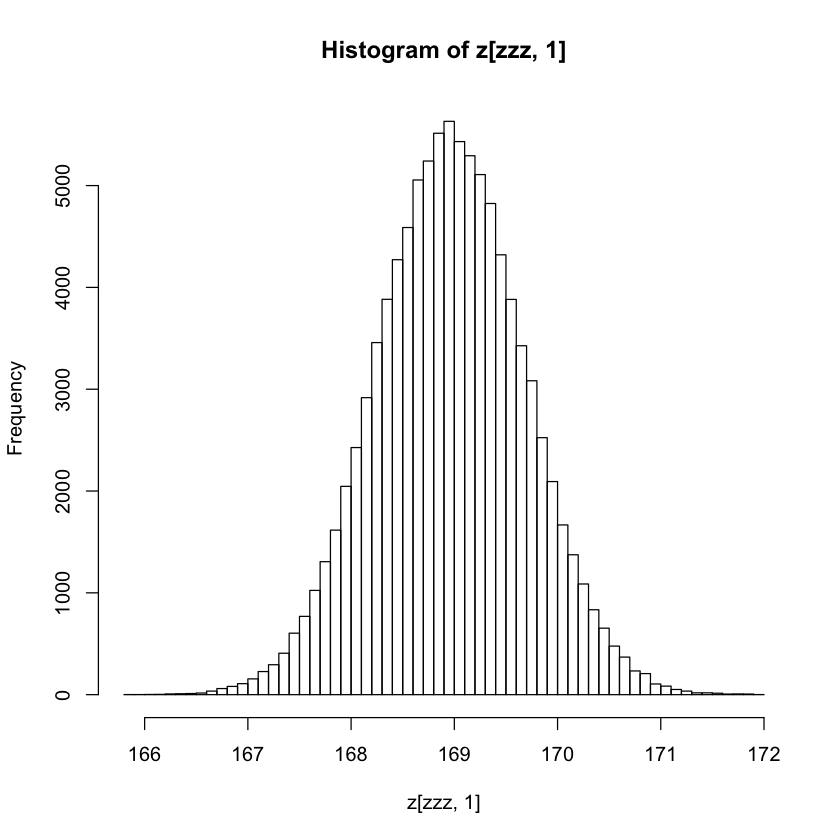

In [8]:
#平均μのヒストグラム
hist(z[zzz,1],breaks = 50,freq =TRUE)

In [9]:
#MAP推定値(最頻値)
rev(sort(table(round(z[zzz,1],1))))[1]

168.9 
 5586

最尤推定値が170なので少々左にずれているが、ほぼ近しい値となっている。

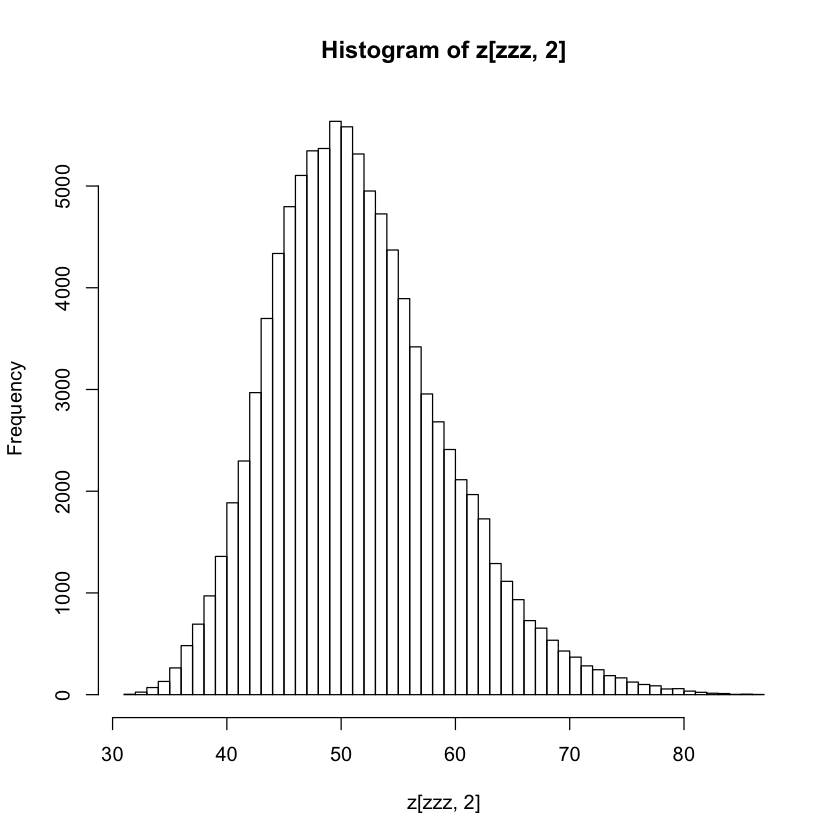

In [10]:
#分散σ^2
hist(z[zzz,2],breaks = 50,freq =TRUE)

In [14]:
#MAP推定値(最頻値)
rev(sort(table(round(z[zzz,2],1))))[1]

48.8 
 599

最尤推定値が49なので、ほぼ近しい値となっている。

平均と分散の値から、かなり正確に正規分布をシミュレートできているよう。
最後に、収束性を確認するためにトレースラインを確認すると全体的に同じ幅の長さで推移していて、十分に収束しているといえる。

Warning message in title(...):
“ 'mbcsToSbcs' 中の 'μ' で変換に失敗: <ce> をドットで置き換えました ”Warning message in title(...):
“ 'mbcsToSbcs' 中の 'μ' で変換に失敗: <bc> をドットで置き換えました ”Warning message in title(...):
“ 'mbcsToSbcs' 中の 'σ2' で変換に失敗: <cf> をドットで置き換えました ”Warning message in title(...):
“ 'mbcsToSbcs' 中の 'σ2' で変換に失敗: <83> をドットで置き換えました ”

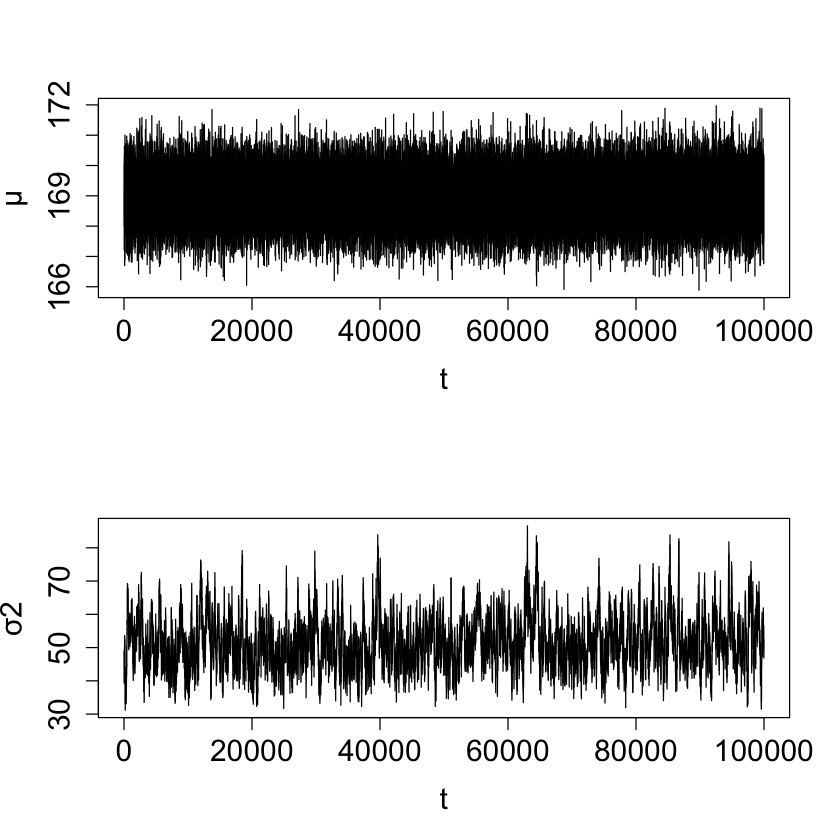

In [15]:
# 正規分布モデルのトレースライン
options(scipen=100)
par(mfrow=c(2,1))
plot(z[,1],type="l",cex.axis=1.5,xlab="t",ylab="μ",cex.lab=1.5)
plot(z[,2],type="l",cex.axis=1.5,xlab="t",ylab="σ2",cex.lab=1.5)
par(mfrow=c(1,1))